# Machine learning: workshop 4


This workshop is not assessed, but it is likely to form part of a later assessed workshop.  The aim of the workshop is to gain some experience of convex optimisation.

# Large margin clasifiers and support vector machines

The aim of this workshop is to write and test code for a nonlinear support vector machine.  This will be done in stages:

1. You will do a couple of exercises to familiarise yourself with constrained optimisation and the Lagrangian dual formulation.
1. Initially, you will write a linear large margin classfier for linearly separable data.
1. The next stage is to modify this code, which uses a *hard margin* to a soft margin.
1.  Finally, you will use the *kernel trick* to map the data to a high-dimensional feature space, while calculating the necessary inner-products in the original data space.

At each stage, you should test your code on the provided data.

In [2]:
%pylab inline
import wget
figsize(10, 8)

data_url = "http://empslocal.ex.ac.uk/people/staff/reverson/ECMM422/"

Populating the interactive namespace from numpy and matplotlib


/Users/reverson/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Constrained optimisation with equality constraints

To begin with we will solve an optimisation problem with equality constraints.  The problem is defined for a two-dimensional $\mathbf{x} = (x_1, x_2)^T$ as follows:
\begin{align*}
    \mbox{min}_\mathbf{x} ~~ f(\mathbf{x}) &= \frac{x_1^2}{2}+ x_2^2\\
    \text{such that}\qquad & x_1 + x_2 = 1
\end{align*}

To see what is going on, make a contour plot of $f(\mathbf{x})$ and draw the contraint line on it.  The following code will draw the contour.  You should add the constraint line. 

You should be able to approximately read the value and location of the contrained minimum from your plot.

(-1.0, 2.0, -1.0, 2.0)

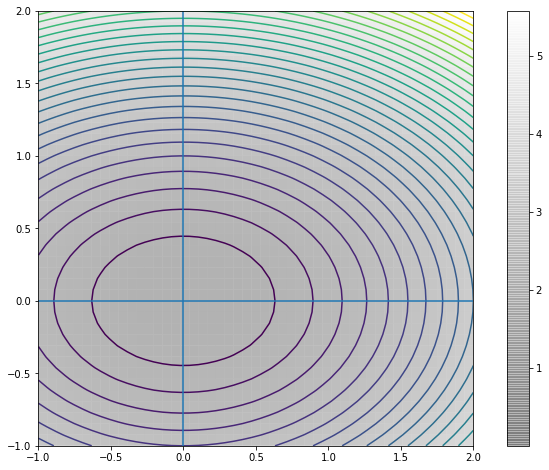

In [9]:
def f(x, y):
    """Evaluate the unconstrained objective function"""
    return x*x/2 + y*y

x = linspace(-1, 2, 50)
y = linspace(-1, 2, 40)
X, Y = meshgrid(x, y)
F = f(X, Y)
axhline(0.0)
axvline(0.0)
pcolor(X, Y, F, cmap='gray', alpha=0.3, edgecolors='')
colorbar()
contour(X, Y, F, 30)

axis('scaled')

Write the contraint in standard form $h(\mathbf{x}) = 0$ and therefore write down the Largrangian, $L(\mathbf{x}, \nu)$.  You could do this and the following cells on a piece of paper, but it's not too hard to put it into LaTeX for posterity.

First, minimise the unconstrained minimisation problem by minimising $L(\mathbf{x}, \nu)$ with respect to $\mathbf{x}$ and $\nu$.  This is done by setting the partial derivatives with respect to $x_1$, $x_2$ and $\nu$ to zero and solving for $x_1$, $x_2$ and $\nu$.


Plot the minimising point on your contour plot and verify that agrees with  the constraint and the function value at the constrained minimum.

Now we will solve the problem again, but this time by finding the Lagrangian dual function, which we will maximise to find the optimal dual variable $\nu$ and thus the optimal $\mathbf{x}$.

By setting the derivative of the Largrangian with respect to $\mathbf{x}$ to zero, find the Largrangian dual function $g(\nu)$.  

Maximise $g(\nu)$ with respect to $\nu$ and so find the optimal dual variable $\nu^\star$ and thus $g(\nu^\star)$.

Use the relations you derived when finding the Lagrangian dual function to get $\mathbf{x}^\star$ from $\nu^\star$.  Thus find $f(\mathbf{x}^\star)$ and verify that it equals $g(\nu^\star)$.

## Quadratic programming

At the heart of the dual formulation of the large margin classifier (LMC) is the quadratic programme with constraints.  For example, for the hard LMC the dual Lagrange function to be *maximised* is:
\begin{align*}
          \newcommand{\balpha}{\mathbf{\alpha}}
          \newcommand{\bx}{\mathbf{x}}
        \max_{\balpha} & ~~ \sum_n \alpha_n - \frac{1}{2} \sum_{n,m}t_n t_m
                         \alpha_n\alpha_m \langle\bx_n, \bx_m\rangle\\
        \text{such that   }\quad & \alpha_n \ge 0, \quad \sum_n \alpha_n t_n = 0
\end{align*}
(see lecture slides).  The data points $\mathbf{x}_n$ corresponding to non-zero $\alpha_n$ are known as *support vectors*.  These are the vectors that define the margin for which the constraints are 'active'; other observations, beyond the margin, have $\alpha_n = 0$ and the constraints corresponding to these $\mathbf{x}_n$ are not active.

### cvxopt
There are a number of quadratic progamme solvers that you could use, but I recommend that you use those from [cvxopt](http://cvxopt.org/).  On the Mac and Blue Room machines you should be able to import the module with:

    import cvxopt
    
If you want to use `cvxopt` on your own machine then you can install it from a shell with `pip`

    pip install cvxopt
    
You may need to install a compiler for this to work.  It should be fine on Linux. On Mac OSX you will need to have `Xcode` installed (free from the App Store and start it up once when you've downloaded it to complete the installation).  

On Windows you may need to work harder, see [Building CVXOPT for Windows](http://cvxopt.org/install/index.html#building-cvxopt-for-windows).   Probably thie easiest thing to do is use the pre-built "wheels on" version. [http://www.lfd.uci.edu/~gohlke/pythonlibs/#cvxopt].  You should then be able to install it from the command window with 

    pip install cvxopt-1.1.9-cp36-none-win_amd64.whl

or substitute the appropriate .whl package. Make sure that you use the `pip` corresponding to the Python that is running your notebook server. An alternative is to use the SciPy `minimize` function; see http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

## `cvxopt` example

Here is an example of solving a constrained quadratic program (QP) with `cvxopt`. This is largely copied from https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

The standard form for a QP in `cvxopt` notation is:

\begin{align*}
        \min_{x}  \tfrac{1}{2} x^T P x &+ q^T x \\
        \text{such that   }\quad  Gx &\preceq h\\
        Ax & = b
\end{align*}
where $Gx \preceq h$ means that the inequality is taken element-wise for each row of $Gx$ and $h$.

In `cvxopt` the QP is defined by the parameters $P, q, G, h, A$ and $b$.  The matrix $P$ and the vector $q$ must be specified, but the others are optional.   Note that all optimisations must be manipulated to be of this form.  In particular, note that you will want to *maximise* the Lagrangian dual $g(\mathbf{\alpha})$, so you will have to write the maximisation as the minimisation of $-g(\mathbf{\alpha})$.

Here is a simple example:

\begin{align*}
        \min_{x}  \tfrac{1}{2} x^2 + & 3x + 4y\\
        \text{such that   }\quad x, y & \ge 0\\
        x + 3y & \ge 15\\
        2x + 5y & \le 100\\
        3x + 4y & \le 80
\end{align*}


Evaluate the objective function on a grid covering the range $[-5, 25] \times [-5, 25]$ and so plot contours of the objective function.  Augment your plot with lines showing the inequalities and so, by eye, find the minimum of the objective function. 

(If you want to be fancy -- not necessary -- you could use the [fillplots](https://github.com/tkf/fillplots) module to plot the region defined by the inequalities.)

The problem can be written in standard form as:

\begin{align*}
  \min_{x, y} \tfrac{1}{2}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}^T
  \begin{bmatrix}
    1 & 0\\
    0 & 0
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}
  +
   \begin{bmatrix}
    3 \\ 4
  \end{bmatrix}^T
 \begin{bmatrix}
    x \\ y
  \end{bmatrix}\\
  \text{with constraints}\qquad
  \begin{bmatrix}
    -1 & 0\\
    0 & -1\\
    -1 & -3\\
    2 & 5\\
    3 & 4
  \end{bmatrix}
  \begin{bmatrix}
    x \\ y
  \end{bmatrix}  
  \preceq
  \begin{bmatrix}
    0 \\ 0 \\ -15 \\ 100 \\ 80
  \end{bmatrix}
\end{align*}

Note that all the inequality constraints have been gathered into the matrix $G$ and that since there are no equality constraints $A$ and $b$ do not need to be specified.  Note
that even though $y^2$ did not appear in the original objective, we had to include it with zero coefficients in $P$ because the solver parameters must be defined using the full set of variables.  Even if certain variables only appear in constraints, they will still need to be expressed with zero coefficients in the objective parameters, and *vice versa*.

Matrices specifying the QP to  `cxvopt` are defined using the `cvxopt` matrices.  Since you will be using `numpy` arrays to store the data for your LMC, we will define the `cvxopt` matrices via `numpy` arrays as follows.  

In [13]:
from cvxopt import matrix

In [14]:
P = matrix(diag([1,0]), tc='d') 
q = matrix(array([3,4]), tc='d')
G = matrix(array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(array([0,0,-15,100,80]), tc='d')

The `tc='d'` argument ensures that the matrices are floating point numbers rather than integers (`tc` stands for "typecode").

Now, at last, we can solve the QP:

In [15]:
from cvxopt import solvers
sol = solvers.qp(P, q, G, h)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  1e-16  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  2e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  2e-16  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  4e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  6e-17  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  3e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  9e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  4e-16
Optimal solution found.


If there were equality constraints (and don't forget that you will have an equality constraint!) you would get the solution with 

    sol = solvers.qp(P, q, G, h, A, b)

Information about the solution can be found from the `sol` dictionary

In [ ]:
print('The solution is\n', sol['x'])
print('The objective is', sol['primal objective'])

More information from the various key-value pairs in the dictionary.  See the [`cxvopt` documentation](http://cvxopt.org/userguide/index.html) for more information on what these mean.

In [ ]:
for k, v in sol.items():
    print(k, v)

Check that the solution you've found agrees with your plot!   You should now be equipped to solve constrained quadratic optimisation problems.

# Hard, large margin classifier

Given a linearly separable training data set `X` and `t`, write a function 

    sv, score = lmc(X, t, Xtest)

to construct a large margin classifier for the data and to classify the data in `Xtest`. 

Your function should construct and solve the Lagrangian dual function for a vector of $\alpha$s.  The the non-zero $\alpha$ correspond the support vectors and your function should return a vector, `sv` of indices of the support vectors in `X` (or a Boolean array indicating the SVs).   Your function should also return a vector, `score`, of the signed distances of each `Xtest` from the optimal hyperplane. The signed distance is the distance from the hyperplane, with the sign specifying which side of the hyperplane the point is on.  It is easily calculated from $\mathbf{w}^T \mathbf{x} + b$.  

Note when classifying an observation $\mathbf{x}$ it is best not to calculate the coefficients $\mathbf{w}$ in order to calculate the discriminant function $\mathbf{w}^T \mathbf{x} + b$.  This is because later, when we use a kernel to map to higher dimensional spaces, $\mathbf{w}$ may be very high dimensional (possibly infinite dimensional).  Instead calculate the discriminant function from the $\mathbf{x}_n, t_n$ and $\alpha_n$.

Test your code on the following two-dimensional separable data.  Plot the data, the separating hyperplane and its margins, together with the support vectors.

In [ ]:
try: 
    separable = loadtxt('separable.txt')
except IOError:
    wget.download(data_url+"separable.txt")
    separable = loadtxt('separable.txt')

X = separable[:,:2]
t = separable[:,2]

plot(X[t==-1,0], X[t==-1,1], 'bo')
plot(X[t==1,0], X[t==1,1], 'rs')

What happens if the data are not separable?  Try it.

To be continued for soft, large margin classifiers and non-linear classifiers. 